In [2]:
%load_ext autoreload
%autoreload 2

In [43]:
from pathlib import Path

model_histories = {
    'nuinsseg-human': Path('models/stardist-nuinsseg-human-20251118_143639/history.pkl'),
    'nuinsseg-mouse': Path('models/stardist-nuinsseg-mouse-20251118_140556/history.pkl'),
    'nuinsseg-human-mouse': Path('models/stardist-nuinsseg-human-mouse-20251118_152635/history.pkl')
}

eval_files = {
    'nuinsseg-human': {
        'val': Path('models/stardist-nuinsseg-human-20251118_143639/validation_evaluation_results.json'),
        'human_test': Path('models/stardist-nuinsseg-human-20251118_143639/human_test_evaluation_results.json'),
        'mouse_test': Path('models/stardist-nuinsseg-human-20251118_143639/mouse_test_evaluation_results.json'),
        'combined_test': Path('models/stardist-nuinsseg-human-20251118_143639/combined_test_evaluation_results.json')
    },
    'nuinsseg-mouse': {
        'val': Path('models/stardist-nuinsseg-mouse-20251118_140556/validation_evaluation_results.json'),
        'mouse_test': Path('models/stardist-nuinsseg-mouse-20251118_140556/mouse_test_evaluation_results.json'),
        'human_test': Path('models/stardist-nuinsseg-mouse-20251118_140556/human_test_evaluation_results.json'),
        'combined_test': Path('models/stardist-nuinsseg-mouse-20251118_140556/combined_test_evaluation_results.json')
    },
    'nuinsseg-human-mouse': {
        'val': Path('models/stardist-nuinsseg-human-mouse-20251118_152635/validation_evaluation_results.json'),
        'human_test': Path('models/stardist-nuinsseg-human-mouse-20251118_152635/human_test_evaluation_results.json'),
        'mouse_test': Path('models/stardist-nuinsseg-human-mouse-20251118_152635/mouse_test_evaluation_results.json'),
        'combined_test': Path('models/stardist-nuinsseg-human-mouse-20251118_152635/combined_test_evaluation_results.json')
    }
}

colors = {'nuinsseg-human': '#ABCAE4',
          'nuinsseg-mouse': "#DC74A0",
          'nuinsseg-human-mouse': '#255075'}

In [44]:
from pathlib import Path

plot_dir = Path('plots/')
plot_dir.mkdir(exist_ok=True)

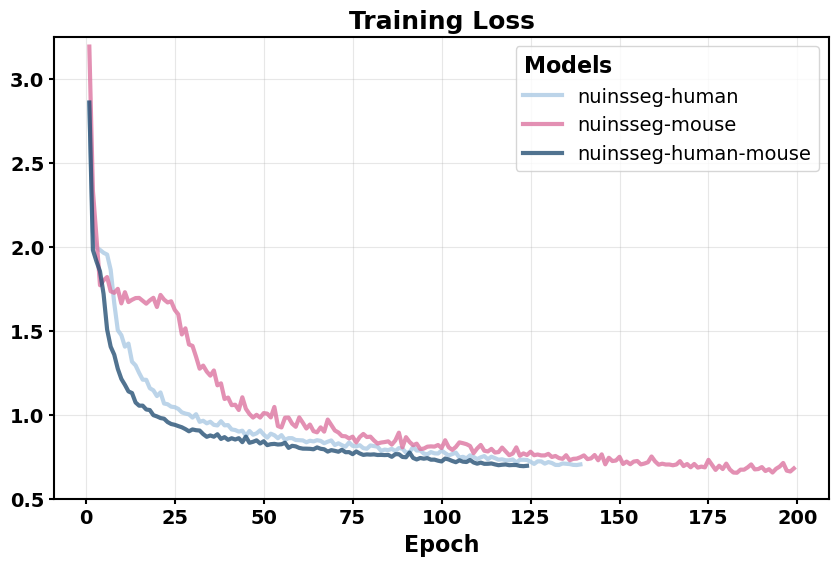

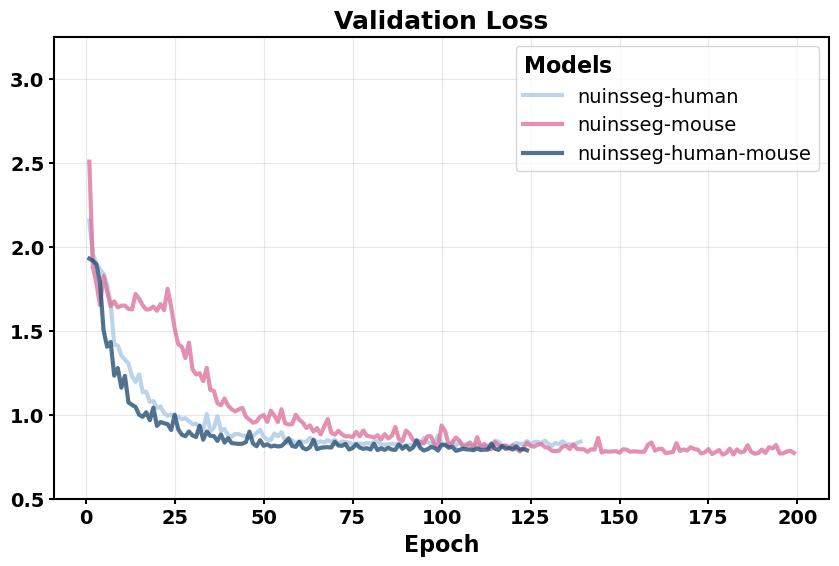

In [45]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

histories = {}
for model_name, path in model_histories.items():
    try:
        with open(path, 'rb') as f:
            histories[model_name] = pickle.load(f)
    except FileNotFoundError:
        continue

loss_types = [
    ('Training Loss', 'loss'),
    ('Validation Loss', 'val_loss')
]

for loss_title, loss_key in loss_types:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set_title(f'{loss_title}', fontsize=18, fontweight='bold')

    for model_name, history in histories.items():
        if loss_key in history:
            epochs = range(1, len(history[loss_key]) + 1)
            ax.plot(epochs, history[loss_key], 
                    label=model_name, 
                    color=colors.get(model_name, 'black'),
                    linewidth=3, alpha=0.8)

    ax.set_xlabel('Epoch', fontsize=16, fontweight='bold')
    ax.set_ybound(0.5, 3.25)
    # ax.set_ylabel(loss_title, fontsize=14)
    ax.legend(title='$\\bf{Models}$', title_fontsize=16, fontsize=14, alignment='left')
    ax.grid(True, alpha=0.3)
    # ax.set_yscale('log')

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    ax.tick_params(width=1.5, labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.savefig(plot_dir / f'stardist_nuinsseg_training_{loss_key}.pdf', bbox_inches='tight', dpi=300)
    
    plt.show()

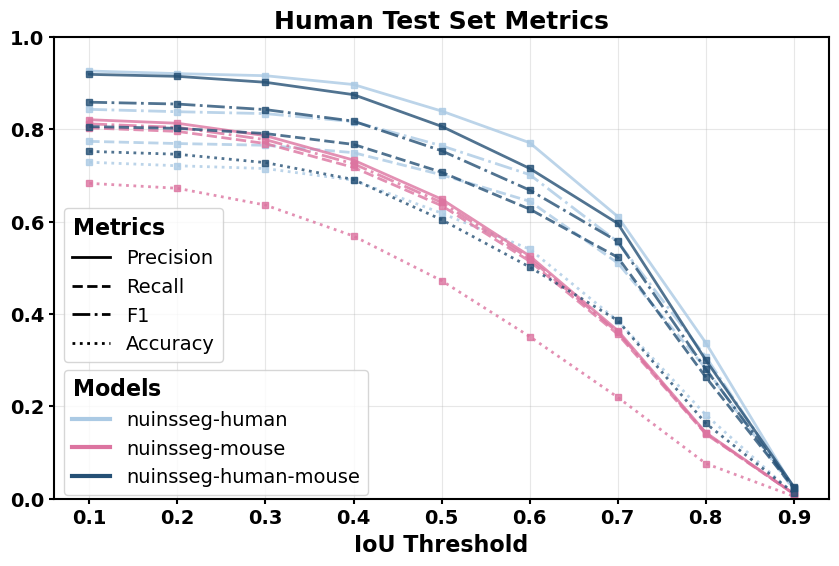

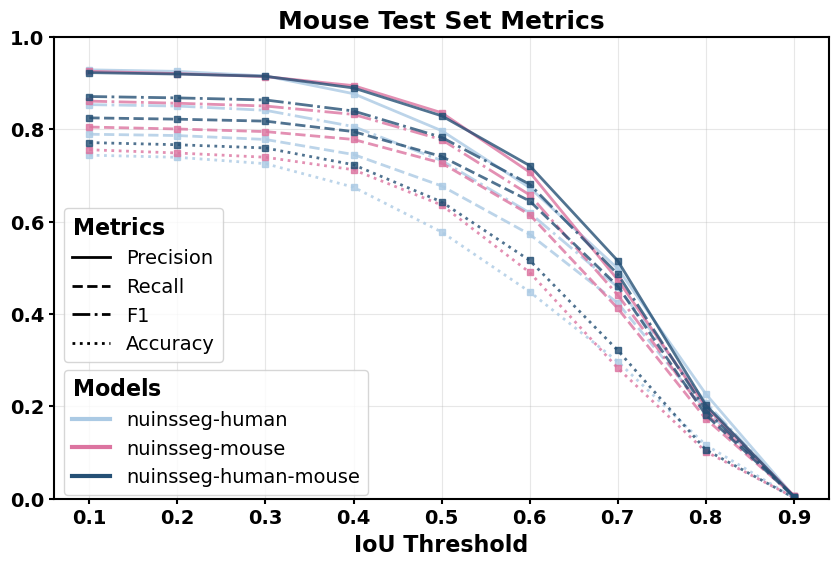

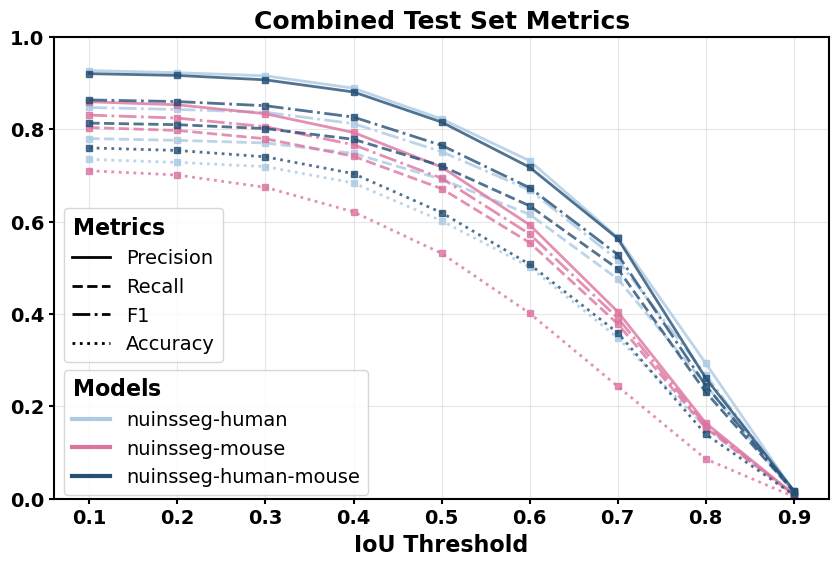

In [46]:
import json
import matplotlib.pyplot as plt

eval_results = {}
for model_name, paths in eval_files.items():
    eval_results[model_name] = {}
    for split, path in paths.items():
        try:
            with open(path, 'r') as f:
                eval_results[model_name][split] = json.load(f)
        except FileNotFoundError:
            continue

# Define line styles and markers for each metric
line_styles = {'precision': '-', 'recall': '--', 'f1': '-.', 'accuracy': ':'}
markers = {'precision': 's', 'recall': 's', 'f1': 's', 'accuracy': 's'}

metrics = ['precision', 'recall', 'f1', 'accuracy']
test_sets = ['human_test', 'mouse_test', 'combined_test']
test_set_titles = {'human_test': 'Human Test Set Metrics', 'mouse_test': 'Mouse Test Set Metrics', 'combined_test': 'Combined Test Set Metrics'}

# Create individual plots for each test set
for test_set in test_sets:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set_title(f'{test_set_titles[test_set]}', fontsize=18, fontweight='bold')
    
    # Plot each model and metric combination for this test set
    for model_name, results in eval_results.items():
        if test_set in results and results[test_set]:
            iou_thresholds = results[test_set]['iou_thresholds']
            stats = results[test_set]['stats']
            
            for metric in metrics:
                values = [stat[metric] for stat in stats]
                
                ax.plot(iou_thresholds, values, 
                       color=colors.get(model_name, 'black'),
                       linestyle=line_styles[metric],
                       marker=markers[metric],
                       markersize=4,
                       linewidth=2,
                       alpha=0.8)
    
    ax.set_xlabel('IoU Threshold', fontsize=16, fontweight='bold')
    ax.set_ylabel('', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    ax.tick_params(width=1.5, labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    
    # Create model legend (colors)
    model_handles = []
    model_labels = []
    for model_name in eval_results.keys():
        if test_set in eval_results[model_name] and eval_results[model_name][test_set]:
            model_handles.append(plt.Line2D([0], [0], color=colors.get(model_name, 'black'), linewidth=3))
            model_labels.append(model_name)
    
    model_legend = ax.legend(model_handles, model_labels, 
                            title='$\\bf{Models}$', title_fontsize=16, fontsize=14,
                            bbox_to_anchor=(0, 0.3), loc='upper left',
                            alignment='left')
    ax.add_artist(model_legend)
    
    # Create metric legend (line styles and markers)
    metric_handles = []
    metric_labels = []
    for metric in metrics:
        metric_handles.append(plt.Line2D([0], [0], color='black', 
                                       linestyle=line_styles[metric],
                                       marker=markers[metric],
                                       markersize=0, linewidth=2))
        metric_labels.append(metric.title())
    
    metric_legend = ax.legend(metric_handles, metric_labels,
                             title='$\\bf{Metrics}$', title_fontsize=16, fontsize=14,
                             bbox_to_anchor=(0, 0.65), loc='upper left',
                             alignment='left')

    plt.savefig(plot_dir / f'stardist_nuinsseg_evaluation_{test_set}_metrics.pdf', bbox_inches='tight', dpi=300)

    plt.show()

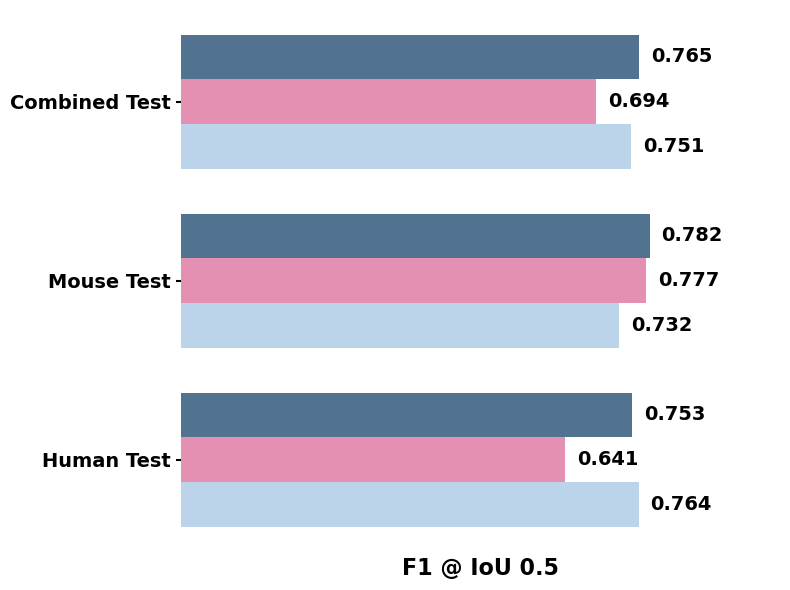

In [47]:
import numpy as np
import matplotlib.pyplot as plt

f1_data = {}
test_set_names = ['human_test', 'mouse_test', 'combined_test']
test_set_labels = ['Human Test', 'Mouse Test', 'Combined Test']

for model_name in eval_results.keys():
    f1_data[model_name] = []
    for test_set in test_set_names:
        if test_set in eval_results[model_name] and eval_results[model_name][test_set]:
            iou_thresholds = eval_results[model_name][test_set]['iou_thresholds']
            stats = eval_results[model_name][test_set]['stats']
            
            iou_05_idx = min(range(len(iou_thresholds)), key=lambda i: abs(iou_thresholds[i] - 0.5))
            f1_score = stats[iou_05_idx]['f1']
            f1_data[model_name].append(f1_score)
        else:
            f1_data[model_name].append(0)  # No data available

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(8, 6))

y = np.arange(len(test_set_labels))  # Test set positions
height = 0.25  # Height of bars

# Plot horizontal bars for each model
for i, (model_name, f1_scores) in enumerate(f1_data.items()):
    ax.barh(y + i * height, f1_scores, height, 
           label=model_name, 
           color=colors.get(model_name, 'black'),
           alpha=0.8)

# Customize the plot
ax.set_xlabel('F1 @ IoU 0.5', fontsize=16, fontweight='bold')
ax.set_yticks(y + height)
ax.set_yticklabels(test_set_labels)
ax.set_xlim([0, 1])

# Remove surrounding box and x-axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.tick_params(bottom=False)

ax.tick_params(width=1.5, labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Add legend
# ax.legend(title='$\\bf{Models}$', title_fontsize=12, fontsize=10, loc='lower right', alignment='left')

# Add value labels on the right of bars
for i, (model_name, f1_scores) in enumerate(f1_data.items()):
    for j, score in enumerate(f1_scores):
        if score > 0:  # Only show labels for non-zero values
            ax.text(score + 0.02, j + i * height, f'{score:.3f}', 
                   ha='left', va='center',
                   fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(plot_dir / f'stardist_nuinsseg_evaluation_F1.pdf', bbox_inches='tight', dpi=300)

plt.show()

In [55]:
def generate_latex_table():
    # Extract metrics at IoU 0.5 for all models and test sets
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    test_sets = ['human_test', 'mouse_test', 'combined_test']
    test_set_names = {'human_test': 'Human Test', 'mouse_test': 'Mouse Test', 'combined_test': 'Combined Test'}
    
    # Collect data
    table_data = {}
    for test_set in test_sets:
        table_data[test_set] = {}
        for model_name in eval_results.keys():
            if test_set in eval_results[model_name] and eval_results[model_name][test_set]:
                iou_thresholds = eval_results[model_name][test_set]['iou_thresholds']
                stats = eval_results[model_name][test_set]['stats']
                
                # Find index closest to IoU 0.5
                iou_05_idx = min(range(len(iou_thresholds)), key=lambda i: abs(iou_thresholds[i] - 0.5))
                
                table_data[test_set][model_name] = {}
                for metric in metrics:
                    table_data[test_set][model_name][metric] = stats[iou_05_idx][metric]
    
    # Find best values for each metric in each test set for bolding
    best_values = {}
    for test_set in test_sets:
        best_values[test_set] = {}
        for metric in metrics:
            if test_set in table_data:
                values = []
                for model_name in table_data[test_set]:
                    if metric in table_data[test_set][model_name]:
                        values.append(table_data[test_set][model_name][metric])
                if values:
                    best_values[test_set][metric] = max(values)
    
    # Generate LaTeX table - Test set-centric layout
    latex_table = """\\begin{table}[htbp]
\\centering
\\caption{Model Performance Comparison at IoU = 0.5}
\\label{tab:model_comparison}
\\begin{tabular}{llcccc}
\\hline
\\textbf{Test Set} & \\textbf{Model} & \\textbf{Accuracy} & \\textbf{Precision} & \\textbf{Recall} & \\textbf{F1} \\\\
\\hline"""
    
    for i, test_set in enumerate(test_sets):
        test_name = test_set_names[test_set]
        models_in_testset = list(table_data[test_set].keys())
        
        for j, model_name in enumerate(models_in_testset):
            if j == 0:  # First model in test set gets the test set name
                row_start = f"\\multirow{{{len(models_in_testset)}}}{{*}}{{{test_name}}}"
            else:
                row_start = ""
            
            # Format metrics to 3 decimal places and bold if best
            metric_values = []
            for metric in metrics:
                if metric in table_data[test_set][model_name]:
                    value = table_data[test_set][model_name][metric]
                    formatted_value = f"{value:.3f}"
                    
                    # Bold if this is the best value for this metric in this test set
                    if (test_set in best_values and 
                        metric in best_values[test_set] and 
                        abs(value - best_values[test_set][metric]) < 1e-6):
                        formatted_value = f"\\textbf{{{formatted_value}}}"
                    
                    metric_values.append(formatted_value)
                else:
                    metric_values.append("N/A")
            
            acc, prec, rec, f1 = metric_values
            
            latex_table += f"""
{row_start} & {model_name} & {acc} & {prec} & {rec} & {f1} \\\\"""
        
        if i < len(test_sets) - 1:  # Add hline between test sets (except after last)
            latex_table += """
\\hline"""
    
    latex_table += """
\\hline
\\end{tabular}
\\end{table}"""
    
    return latex_table

# Generate and display the table
latex_output = generate_latex_table()
print("LaTeX Table:")
print("=" * 50)
print(latex_output)

# Also save to file
with open(plot_dir / 'metrics_table.tex', 'w') as f:
    f.write(latex_output)
print(f"\nTable saved to: {plot_dir / 'metrics_table.tex'}")

LaTeX Table:
\begin{table}[htbp]
\centering
\caption{Model Performance Comparison at IoU = 0.5}
\label{tab:model_comparison}
\begin{tabular}{llcccc}
\hline
\textbf{Test Set} & \textbf{Model} & \textbf{Accuracy} & \textbf{Precision} & \textbf{Recall} & \textbf{F1} \\
\hline
\multirow{3}{*}{Human Test} & nuinsseg-human & \textbf{0.618} & \textbf{0.839} & 0.701 & \textbf{0.764} \\
 & nuinsseg-mouse & 0.472 & 0.648 & 0.634 & 0.641 \\
 & nuinsseg-human-mouse & 0.604 & 0.806 & \textbf{0.707} & 0.753 \\
\hline
\multirow{3}{*}{Mouse Test} & nuinsseg-human & 0.577 & 0.797 & 0.677 & 0.732 \\
 & nuinsseg-mouse & 0.636 & \textbf{0.836} & 0.727 & 0.777 \\
 & nuinsseg-human-mouse & \textbf{0.643} & 0.829 & \textbf{0.741} & \textbf{0.782} \\
\hline
\multirow{3}{*}{Combined Test} & nuinsseg-human & 0.601 & \textbf{0.822} & 0.692 & 0.751 \\
 & nuinsseg-mouse & 0.531 & 0.718 & 0.671 & 0.694 \\
 & nuinsseg-human-mouse & \textbf{0.619} & 0.815 & \textbf{0.720} & \textbf{0.765} \\
\hline
\end{tabular}
\end